In [207]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [208]:
from Data_handler import Data, RF_COL
from termcolor import colored

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import os

# 2 Loading the data

In [209]:
# Prepare data
Data_instance = Data()               # create instance of the class Data()
data = Data_instance.get_data()      # store the data of Data_instance

Data has been loaded from local files. Only data with more than 36 observations has been kept.


In [210]:
data.sort_values(by=['permno','date'],inplace=True)
print(data.shape)

(1439408, 10)


# 3 Betting Against Beta

In [211]:
data.groupby('date').first().sort_values(by='date')

,permno,ret,shrout,prc,siccd,mcap,mcap_l,tmytm,vwretd
date,,,,,,,,,
1964-01-31,10006,0.068548,2948.0,66.25,3743,195305.00,202675.00,0.002873,0.025790
1964-02-28,10006,0.043774,2948.0,68.75,3743,202675.00,202675.00,0.002945,0.017207
1964-03-31,10006,0.000000,2948.0,68.75,3743,202675.00,203412.00,0.002940,0.017636
1964-04-30,10006,0.003636,2948.0,69.00,3743,203412.00,199727.00,0.002797,0.004607
1964-05-28,10006,-0.010870,2948.0,67.75,3743,199727.00,214835.50,0.002721,0.017403
...,...,...,...,...,...,...,...,...,...
2023-08-31,10028,-0.319092,26897.0,5.10,5094,137174.70,127491.78,0.004463,-0.020605
2023-09-29,10028,-0.070588,26897.0,4.74,5094,127491.78,105436.24,0.004472,-0.047390
2023-10-31,10028,-0.172996,26897.0,3.92,5094,105436.24,116946.00,0.004475,-0.028867


## Question a)

In [212]:
# Add excess returns
data['Rn_e'] = data['ret'] - data[RF_COL]
data['Rm_e'] = data['vwretd'] - data[RF_COL]

# Drop nan values
data = data.dropna().copy()

# Rolling betas for each stock, based on 5-year windows (code from PS5)
w = 5 * 12  # window size
covariance = data.set_index('date').groupby('permno')[['Rn_e', 'Rm_e']].rolling(window=w, min_periods=36).cov()
betas = covariance.iloc[1::2,1].droplevel(2) / covariance.iloc[0::2,1].droplevel(2)
betas = betas.dropna().reset_index().rename(columns={'Rm_e': 'beta'})

# Make sure the dates columns are datetime
betas.date = pd.to_datetime(betas.date)
data.date = pd.to_datetime(data.date)

# Offset the dates of the betas by 1 month (code from PS5)
betas.date = betas.date + pd.DateOffset(months=1)

# Merge the full data with betas (code from PS5)
data_Qb = pd.merge(data, betas, on=['permno', 'date'], how='left')

# Finally, we winsorize the betas (5% and 95%) (code from PS5)
data_Qb['beta'] = data_Qb['beta'].clip(data_Qb['beta'].quantile(0.05), data_Qb['beta'].quantile(0.95))

# Drop all nan
data_Qb = data_Qb.dropna().copy()

print('Distribution of betas:')
print(data_Qb['beta'].describe(), '\n')


display(data_Qb.head()) # Overview of the data
print(data_Qb.shape)

Distribution of betas:
count    403329.000000
mean          1.128585
std           0.709760
min           0.418732
25%           0.654756
50%           0.892282
75%           1.317294
max           3.181977
Name: beta, dtype: float64 


,permno,date,ret,shrout,prc,siccd,mcap,mcap_l,tmytm,vwretd,Rn_e,Rm_e,beta
36,10001,2013-01-31,0.062701,8157.0,9.87,4925,80509.59,81080.58,0.000051,0.054142,0.062650,0.054091,2.152012
37,10001,2013-02-28,0.011651,8157.0,9.94,4925,81080.58,83201.40,0.000040,0.008282,0.011611,0.008242,2.064342
38,10001,2013-03-28,0.030684,8157.0,10.20,4925,83201.40,86668.70,0.000034,0.035295,0.030650,0.035261,2.065339
44,10001,2013-09-30,0.004412,10372.0,10.20,4925,105794.40,103408.84,0.000017,0.037497,0.004395,0.037480,2.084554
48,10001,2014-01-31,0.147572,10452.0,9.17,4925,95844.84,97830.72,0.000042,-0.030020,0.147530,-0.030062,2.327879


(403329, 13)


In [213]:
# data_Qb = data.copy().dropna() # Uncomment if decide to use the class method to get the rolling betas, which gives different results 😃
print("Initial number of observations: ", data.shape[0])
print("Final number of observations: \t", data_Qb.shape[0])

Initial number of observations:  1420791
Final number of observations: 	 403329


## Question b)

### Equally weighted portfolios

In [214]:
# Create deciles based on Beta value (code from PS5)
data_Qb["EW_monthly_decile"] = data_Qb.groupby("date")["beta"].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

# Equally weighted returns per month, for each decile
EW_returns = data_Qb.groupby(["date", "EW_monthly_decile"]).agg({
    'ret': 'mean',
    RF_COL: 'first',
    'EW_monthly_decile': 'first',
    'date': 'first'
    }).reset_index(drop=True).rename(columns={'EW_monthly_decile': 'decile'})

print("Equally weighted returns per month, for each decile:")
display(EW_returns.head(5))

Equally weighted returns per month, for each decile:


,ret,tmytm,decile,date
0,0.056276,0.003737,0,1967-02-28
1,0.037079,0.003737,1,1967-02-28
2,0.040213,0.003737,2,1967-02-28
3,0.035698,0.003737,3,1967-02-28
4,0.035058,0.003737,4,1967-02-28


In [215]:
# Value weighted returns per month, for each decile
data_Qb['VW_weight'] = data_Qb.groupby(['date', 'EW_monthly_decile'])['mcap'].transform(lambda x: x / x.sum())
data_Qb['VW_ret_contrib'] = data_Qb['VW_weight'] * data_Qb['ret']

VW_returns = data_Qb.groupby(["date", "EW_monthly_decile"]).agg({
    'VW_ret_contrib': 'sum',
    RF_COL: 'first',
    'EW_monthly_decile': 'first',
    'date': 'first'
    }).reset_index(drop=True).rename(columns={'EW_monthly_decile': 'decile', 'VW_ret_contrib': 'ret'})

print("Value weighted returns per month, for each decile:")
display(VW_returns.head(5))

Value weighted returns per month, for each decile:


,ret,tmytm,decile,date
0,0.025554,0.003737,0,1967-02-28
1,-0.000369,0.003737,1,1967-02-28
2,0.029992,0.003737,2,1967-02-28
3,0.017647,0.003737,3,1967-02-28
4,0.005286,0.003737,4,1967-02-28


### Plot the mean returns, volatility, and sharpe ratios for EW and VW portfolios

#### Auxiliary functions for plots

In [216]:
def get_mean_std_sharpe(data):
    """Compute the annulalized mean, standard deviation and Sharpe ratio for each decile."""
    mean = list(map(lambda x: 12*x, data.groupby('decile')['ret'].mean().values.tolist()))
    std = list(map(lambda x: np.sqrt(12)*x, data.groupby('decile')['ret'].std().values.tolist()))
    rf = np.mean(list(map(lambda x: 12*x, data.groupby('decile')[RF_COL].mean().values.tolist())))
    sr = list(map(lambda ret, vol: (ret - rf) / vol, mean, std))
    
    return mean, std, sr

def plot_from_lists(mean, std, sharpe, plot_color = 'blue'):
    deciles = list(range(len(mean)))

    a, axs = plt.subplots(1, 3, figsize=(25, 7), sharey=False)

    axs[0].bar(deciles, mean, color=plot_color)
    axs[0].set_title("Average portolio mean return")
    axs[0].set_xticks(deciles)
    axs[0].set_xlabel("Decile")
    axs[0].set_ylabel("Annualized return")

    axs[1].bar(deciles, std, color=plot_color)
    axs[1].set_title("Average portolio annualized standard deviation")
    axs[1].set_xticks(deciles)
    axs[1].set_xlabel("Decile")
    axs[1].set_ylabel("Annualized standard deviation")

    axs[2].bar(deciles, sharpe, color=plot_color)
    axs[2].set_title("Average portolio annualized sharpe ratio")
    axs[2].set_xticks(deciles)
    axs[2].set_xlabel("Decile")
    axs[2].set_ylabel("Annualized sharpe ratio")
    
    return plt

def plot_mean_std_sr(data, question, plot_name, show = True):
    """Takes a dataframe in input and returns a 3 graphs for the  annualized mean, std and sharpe ratio for some deciles."""

    if not os.path.exists("Figures"):
            os.makedirs("Figures")
    
    mean, std, sharpe = get_mean_std_sharpe(data)

    plot = plot_from_lists(mean, std, sharpe, plot_color = 'blue')

    if show:
        plot.suptitle(f'Average portolio annualized mean return, standard deviation and sharpe ratio ({plot_name})')
        plot.savefig(f"Figures/question_{question}_plot_{plot_name}")
        plot.show()

#### Plots

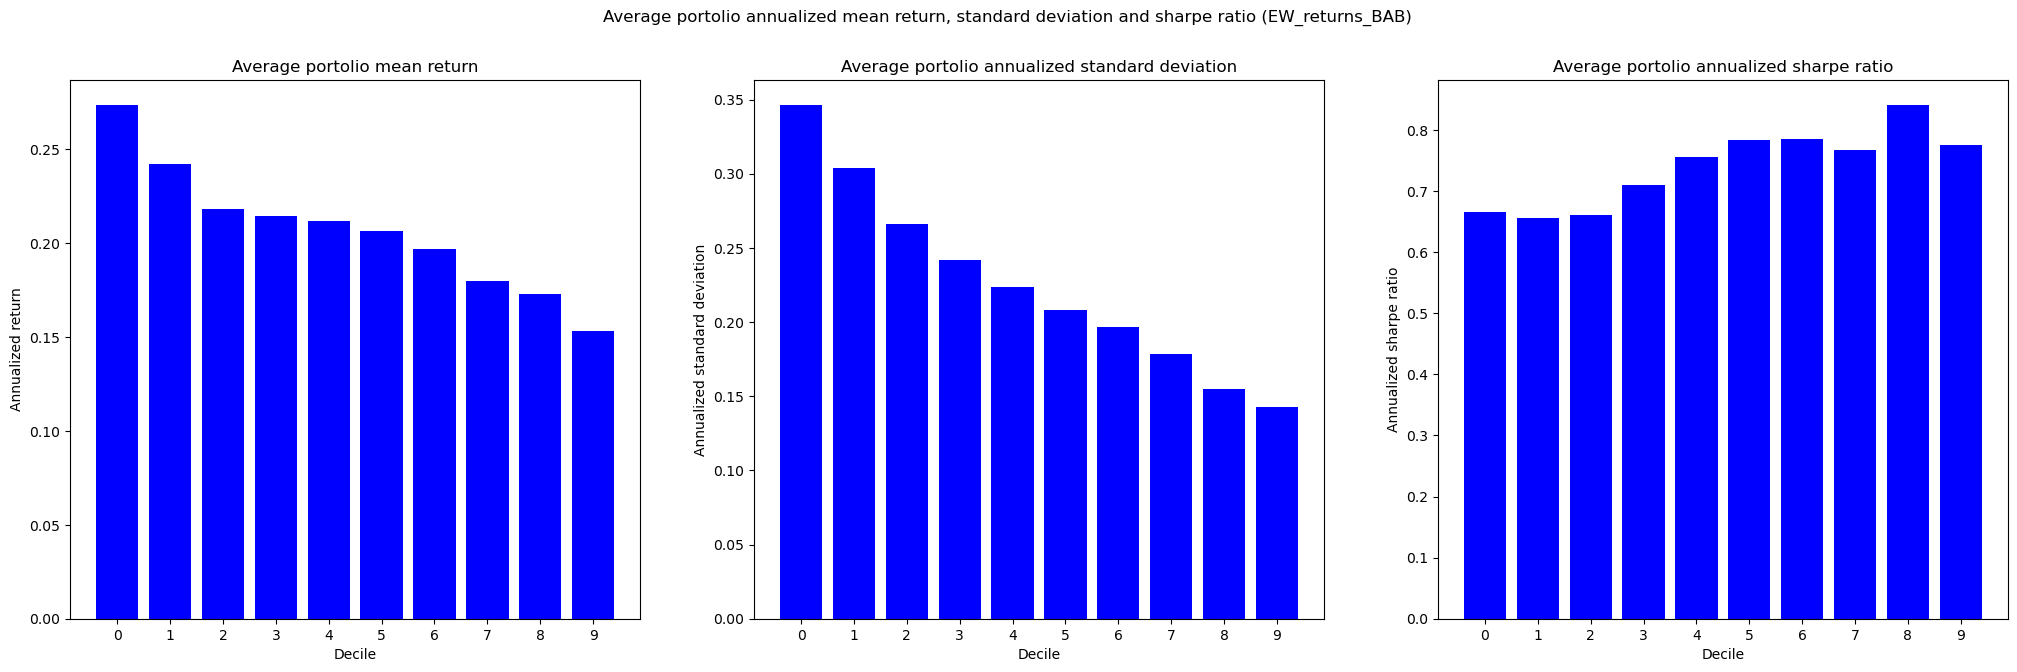

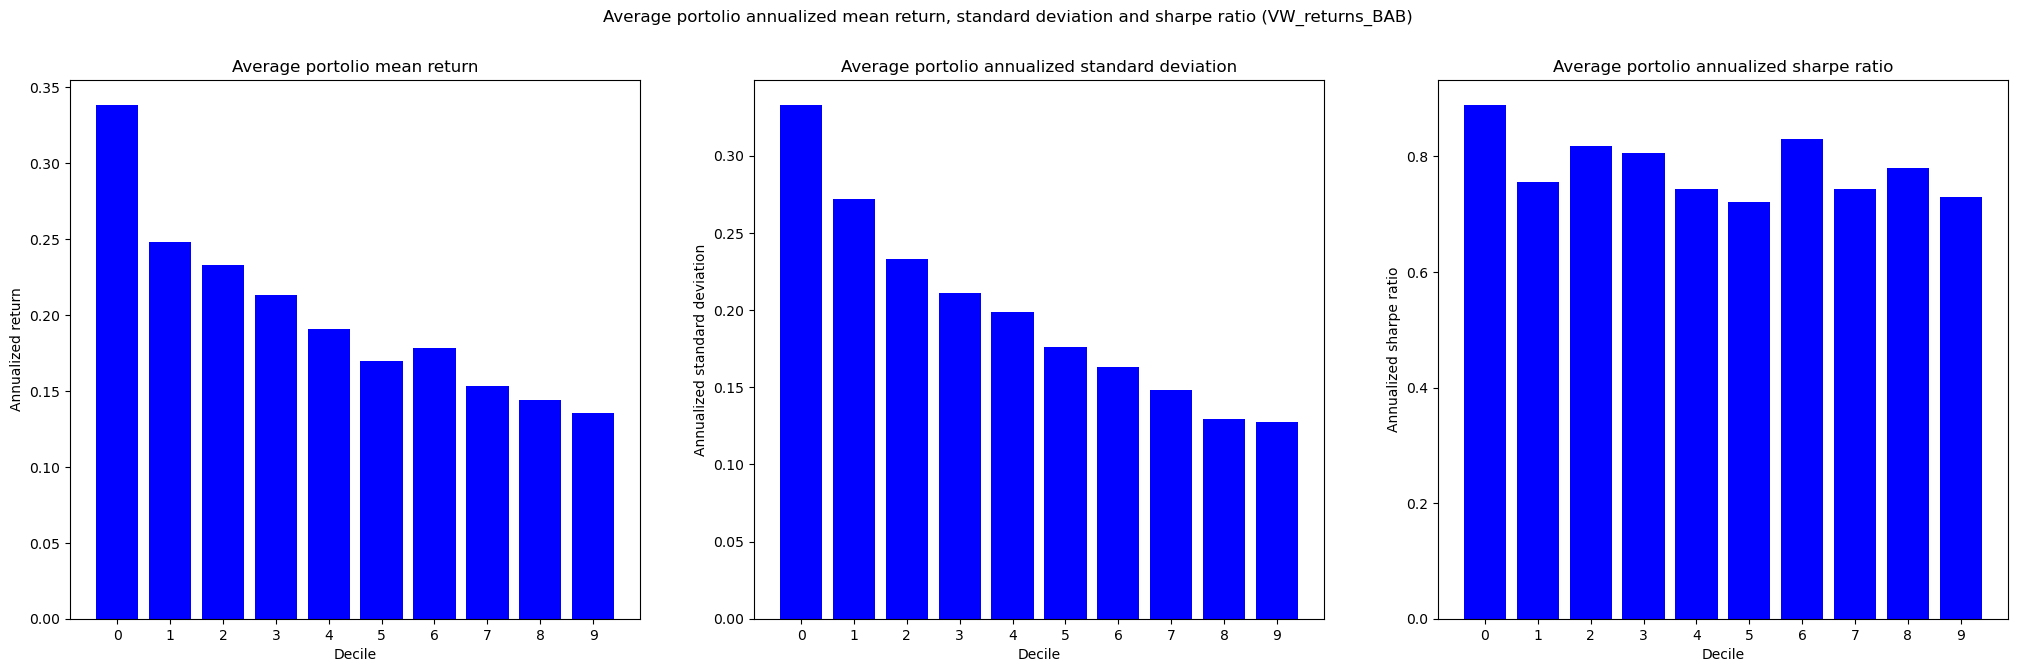

In [217]:
# Plot the results for the 2 different weightings
plot_mean_std_sr(EW_returns, '3b', "EW_returns_BAB")
plot_mean_std_sr(VW_returns, '3b', "VW_returns_BAB")

## Question c) and d)

### Built the function for determining BAB weights

In [276]:
def get_bab_weights(data):
    """Computes the weights of the Betting-Against-Beta portfolio (code inspired from PS5)."""
    df = data.copy()
    df['z'] = df.groupby('date')['beta'].rank()                     # Assign each beta a rank, for each month
    df['z_mean'] = df.groupby('date')['z'].transform('mean')        # Calculate the monthly mean the rank
    df['norm'] = np.abs(df['z']- df['z_mean'])                      # Compute abs distance of rank to mean rank
    df['sum_norm'] = df.groupby('date')['norm'].transform("sum")    # Sum the distance
    df['k'] = 2 / df['sum_norm']                                    # Compute the k

    # Compute the BAB weights
    df['wH'] = df['k'] * np.maximum(0, df['z'] - df['z_mean'])
    df['wL'] = - df['k'] * np.minimum(0, df['z'] - df['z_mean'])

    # Drop irrelevant columns
    df = df.drop(columns=["z_mean", 'z', 'norm', 'sum_norm', 'k'])

    # Compute the weighted betas
    df['bH'] = df['wH'] * df['beta']
    df['bL'] = df['wL'] * df['beta']

    # Compute the individual excess returns of the portfolios H and L
    df['rH_e'] = df['wH'] * (df['ret'] - df[RF_COL])
    df['rL_e'] = df['wL'] * (df['ret'] - df[RF_COL]) # Check that crazy formula bby 😃  (en gros, c'est okay de faire weight * excess return au lieu de faire weight * excess return?)
    
    # Compute the return and betas of the two portfolios for each period
    df_ = df.groupby('date').agg({
        'rH_e': 'sum',
        'rL_e': 'sum',
        'bH': 'sum',
        'bL': 'sum',
        'Rm_e': 'first',
    }).reset_index()

    # Finally create the BAB portfolio return
    df_['rBAB'] = df_['rL_e'] / df_['bL'] - df_['rH_e'] / df_['bH']

    return df_, df[["permno", "date", "wH", "wL"]]

In [277]:
# Create the weights rBAB
data_BAB, weights_BAB = get_bab_weights(data_Qb)
display(data_BAB)

,date,rH_e,rL_e,bH,bL,Rm_e,rBAB
0,1967-02-28,0.027008,0.044732,1.571689,0.479830,0.007208,0.076040
1,1967-06-30,0.038501,0.119292,1.719534,0.501746,0.023813,0.215364
2,1967-08-31,0.010056,0.000986,1.667025,0.496637,-0.009498,-0.004047
3,1967-11-30,0.000488,-0.002625,1.665222,0.500879,0.004411,-0.005534
4,1968-02-29,-0.040042,-0.077970,1.806432,0.515194,-0.037518,-0.129175
...,...,...,...,...,...,...,...
241,2022-12-30,-0.042119,-0.069399,1.690825,0.551150,-0.060446,-0.101007
242,2023-02-28,-0.022995,-0.035494,1.684411,0.547167,-0.028348,-0.051217
243,2023-06-30,0.053043,0.120641,1.683091,0.546913,0.061881,0.189069
244,2023-08-31,-0.033604,-0.062364,1.682505,0.544641,-0.025068,-0.094532


In [278]:
display(weights_BAB)

,permno,date,wH,wL
36,10001,2013-01-31,0.002520,-0.000000
37,10001,2013-02-28,0.002468,-0.000000
38,10001,2013-03-28,0.002461,-0.000000
44,10001,2013-09-30,0.002493,-0.000000
48,10001,2014-01-31,0.002675,-0.000000
...,...,...,...,...
1420778,93426,2022-12-30,0.000000,0.000639
1420780,93426,2023-02-28,0.000000,0.000506
1420784,93426,2023-06-30,0.000000,0.000543
1420786,93426,2023-08-31,0.000000,0.000422


### Get the return, std and sharpe ratio of the BAB strategy

In [220]:
# We compute the rf based on question b) results, as the underlying data is the same
rf = np.mean(list(map(lambda x: 12*x, VW_returns.groupby('decile')[RF_COL].mean().values.tolist())))

# Compute the return, std and Sharpe ratio of the BAB strategy
BAB_ret = data_BAB.rBAB.mean() * 12
BAB_std = data_BAB.rBAB.std() * np.sqrt(12)
BAB_shr = (BAB_ret - rf) / BAB_std

# Compute the CAPM alpha
data_BAB['one'] = 1 # Create the column for the constant
model = sm.OLS(data_BAB['rBAB'], data_BAB[['one', 'Rm_e']]).fit() # Fit CAPM

print(colored("Betting-against-beta strategy", "blue", attrs=['underline', 'bold']))
print(" - Mean return: {:.2f}".format(BAB_ret))
print(" - Standard deviation: {:.2f}".format(BAB_std))
print(" - Sharpe ratio: {:.2f}".format(BAB_shr))
print(" - CAPM alpha: {:.2f}".format(model.params.iloc[0] * 12))

Betting-against-beta strategy
 - Mean return: 0.29
 - Standard deviation: 0.45
 - Sharpe ratio: 0.54
 - CAPM alpha: 0.12


# 4 Momentum Strategy

## Question a)

### Create the deciles based on the 12-month cumulative return, excluding short term reversal

In [221]:
data.sort_values(by=['permno', 'date'], inplace=True)
display(data.head())

,permno,date,ret,shrout,prc,siccd,mcap,mcap_l,tmytm,vwretd,Rn_e,Rm_e
6,10001,2009-12-31,0.162621,4361.0,10.3000,4925,44918.3000,43871.6600,0.000032,0.028475,0.162589,0.028443
5,10001,2010-01-29,-0.018932,4361.0,10.0600,4925,43871.6600,43646.6324,0.000013,-0.037172,-0.018945,-0.037185
4,10001,2010-02-26,-0.000656,4361.0,10.0084,4925,43646.6324,44351.3700,0.000061,0.034744,-0.000717,0.034683
3,10001,2010-03-31,0.020643,4361.0,10.1700,4925,44351.3700,69137.3000,0.000112,0.063668,0.020531,0.063556
2,10001,2010-04-30,0.124385,6070.0,11.3900,4925,69137.3000,69209.4000,0.000118,0.020036,0.124267,0.019918


In [222]:
# Sort data by permno, then date
data_mom = data.copy()
data_mom.sort_values(by=['permno', 'date'], inplace=True)

# Add a column for momentum return (last 12 months, excluding last month)
data_mom['roll_ret'] = data_mom.groupby('permno').ret.transform(lambda x: x.rolling(11, closed='left').sum())
display(data_mom.head())

,permno,date,ret,shrout,prc,siccd,mcap,mcap_l,tmytm,vwretd,Rn_e,Rm_e,roll_ret
6,10001,2009-12-31,0.162621,4361.0,10.3000,4925,44918.3000,43871.6600,0.000032,0.028475,0.162589,0.028443,NaN
5,10001,2010-01-29,-0.018932,4361.0,10.0600,4925,43871.6600,43646.6324,0.000013,-0.037172,-0.018945,-0.037185,NaN
4,10001,2010-02-26,-0.000656,4361.0,10.0084,4925,43646.6324,44351.3700,0.000061,0.034744,-0.000717,0.034683,NaN
3,10001,2010-03-31,0.020643,4361.0,10.1700,4925,44351.3700,69137.3000,0.000112,0.063668,0.020531,0.063556,NaN
2,10001,2010-04-30,0.124385,6070.0,11.3900,4925,69137.3000,69209.4000,0.000118,0.020036,0.124267,0.019918,NaN


In [223]:
# Create deciles for the momentum returns
data_mom['decile_mom'] = data_mom.groupby('date')['roll_ret'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

# Compute the monthly return for each decile (this is the average of the individual monthly return of each stock from each decile)
data_mom['EW_monthly_return'] = data_mom.groupby(['date', 'decile_mom'])['ret'].transform('mean')

# Drop nan values
data_mom = data_mom.dropna().copy()

display(data_mom.head())
print(data_mom.shape)
# data_mom.to_csv('data_mom.csv')

,permno,date,ret,shrout,prc,siccd,mcap,mcap_l,tmytm,vwretd,Rn_e,Rm_e,roll_ret,decile_mom,EW_monthly_return
86,10001,2010-12-31,0.052291,7834.0,10.52,4925,82413.68,84450.52,0.000068,0.067182,0.052223,0.067114,0.255899,6.0,0.075916
85,10001,2011-01-31,0.028992,7834.0,10.78,4925,84450.52,86017.32,0.000125,0.019183,0.028867,0.019058,0.145569,2.0,0.027231
84,10001,2011-02-28,0.022727,7834.0,10.98,4925,86017.32,91892.82,0.000065,0.038156,0.022662,0.038091,0.193493,4.0,0.060445
83,10001,2011-03-31,0.072404,7834.0,11.73,4925,91892.82,91535.73,0.000049,0.003341,0.072355,0.003292,0.216876,5.0,0.014937
82,10001,2011-04-29,-0.038789,8151.0,11.23,4925,91535.73,93736.50,0.000013,0.028597,-0.038802,0.028584,0.268637,6.0,0.020016


(1323032, 15)


### Equally weighted portfolios

In [224]:
# Equally weighted returns per month, for each decile
EW_returns_mom = data_mom.groupby(['date', 'decile_mom']).agg({
    'ret': 'mean',
    RF_COL: 'first',
    'decile_mom': 'first',
    'date': 'first'
    }).reset_index(drop=True).rename(columns={'decile_mom': 'decile'})

print(colored("Equally weighted returns per month, for each decile:", "blue", attrs=['underline', 'bold']))
display(EW_returns_mom.head(5))
print(EW_returns_mom.shape)

Equally weighted returns per month, for each decile:


,ret,tmytm,decile,date
0,-0.043278,0.002856,0.0,1964-12-31
1,-0.009028,0.002856,1.0,1964-12-31
2,-0.005590,0.002856,2.0,1964-12-31
3,0.000432,0.002856,3.0,1964-12-31
4,-0.002579,0.002856,4.0,1964-12-31


(7080, 4)


### Value weighted portfolios

In [225]:
# Value weighted returns per month, for each decile
data_mom['VW_weight'] = data_mom.groupby(['date', 'decile_mom'])['mcap'].transform(lambda x: x / x.sum())
data_mom['VW_ret_contrib'] = data_mom['VW_weight'] * data_mom['ret']

VW_returns_mom = data_mom.groupby(["date", "decile_mom"]).agg({
    'VW_ret_contrib': 'sum',
    RF_COL: 'first',
    'decile_mom': 'first',
    'date': 'first'
    }).reset_index(drop=True).rename(columns={'decile_mom': 'decile', 'VW_ret_contrib': 'ret'})

print(colored("Value weighted returns per month, for each decile:", "blue", attrs=['underline', 'bold']))
display(VW_returns_mom.head(5))
print(VW_returns_mom.shape)

Value weighted returns per month, for each decile:


,ret,tmytm,decile,date
0,-0.004562,0.002856,0.0,1964-12-31
1,0.000245,0.002856,1.0,1964-12-31
2,0.015507,0.002856,2.0,1964-12-31
3,0.013461,0.002856,3.0,1964-12-31
4,-0.004111,0.002856,4.0,1964-12-31


(7080, 4)


### Plotting the graphs

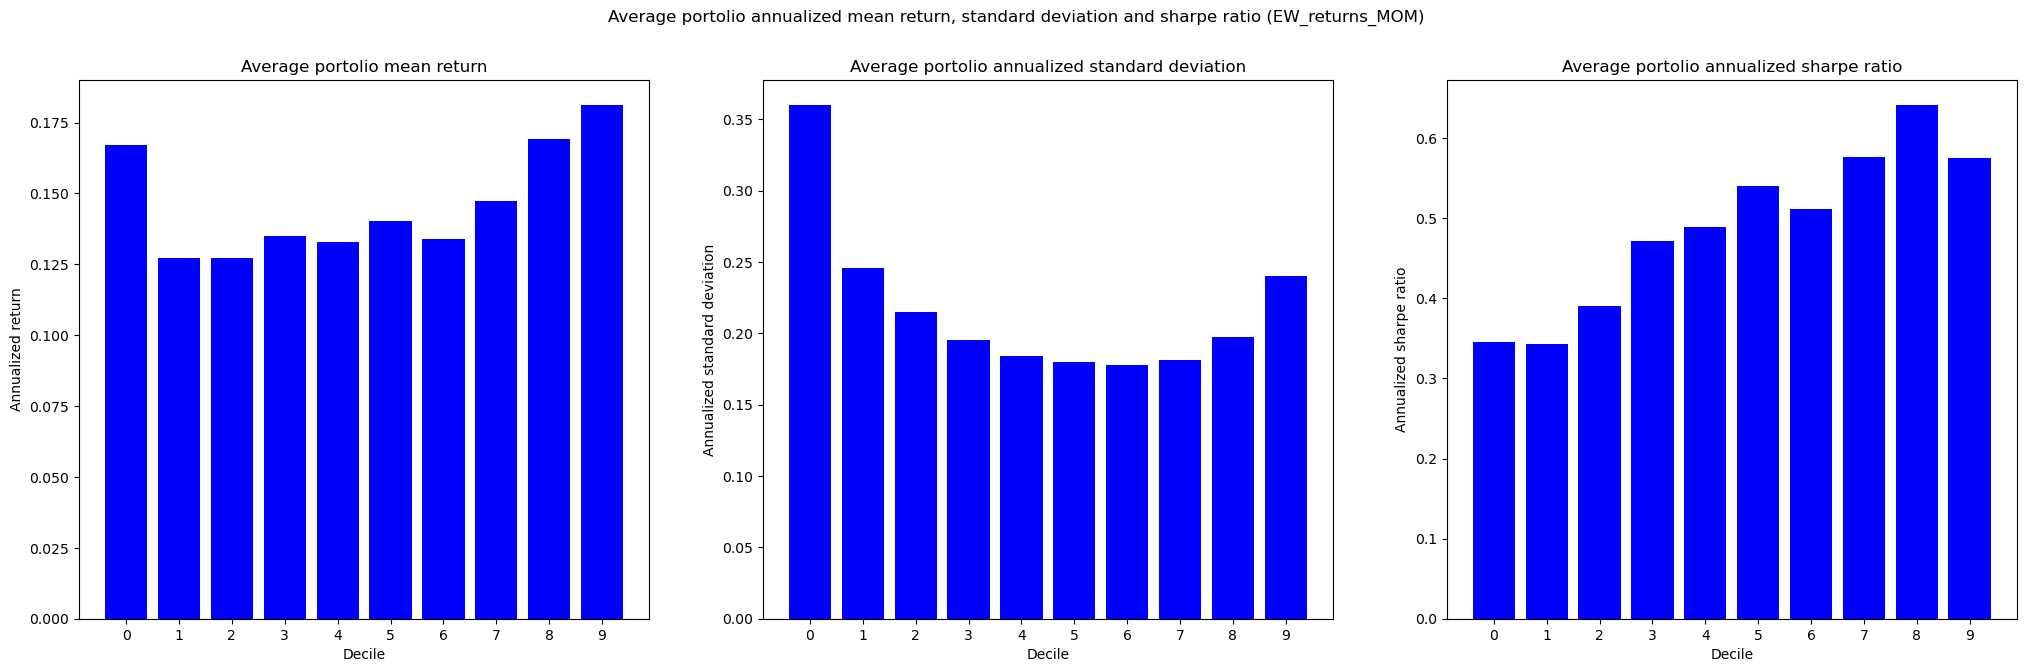

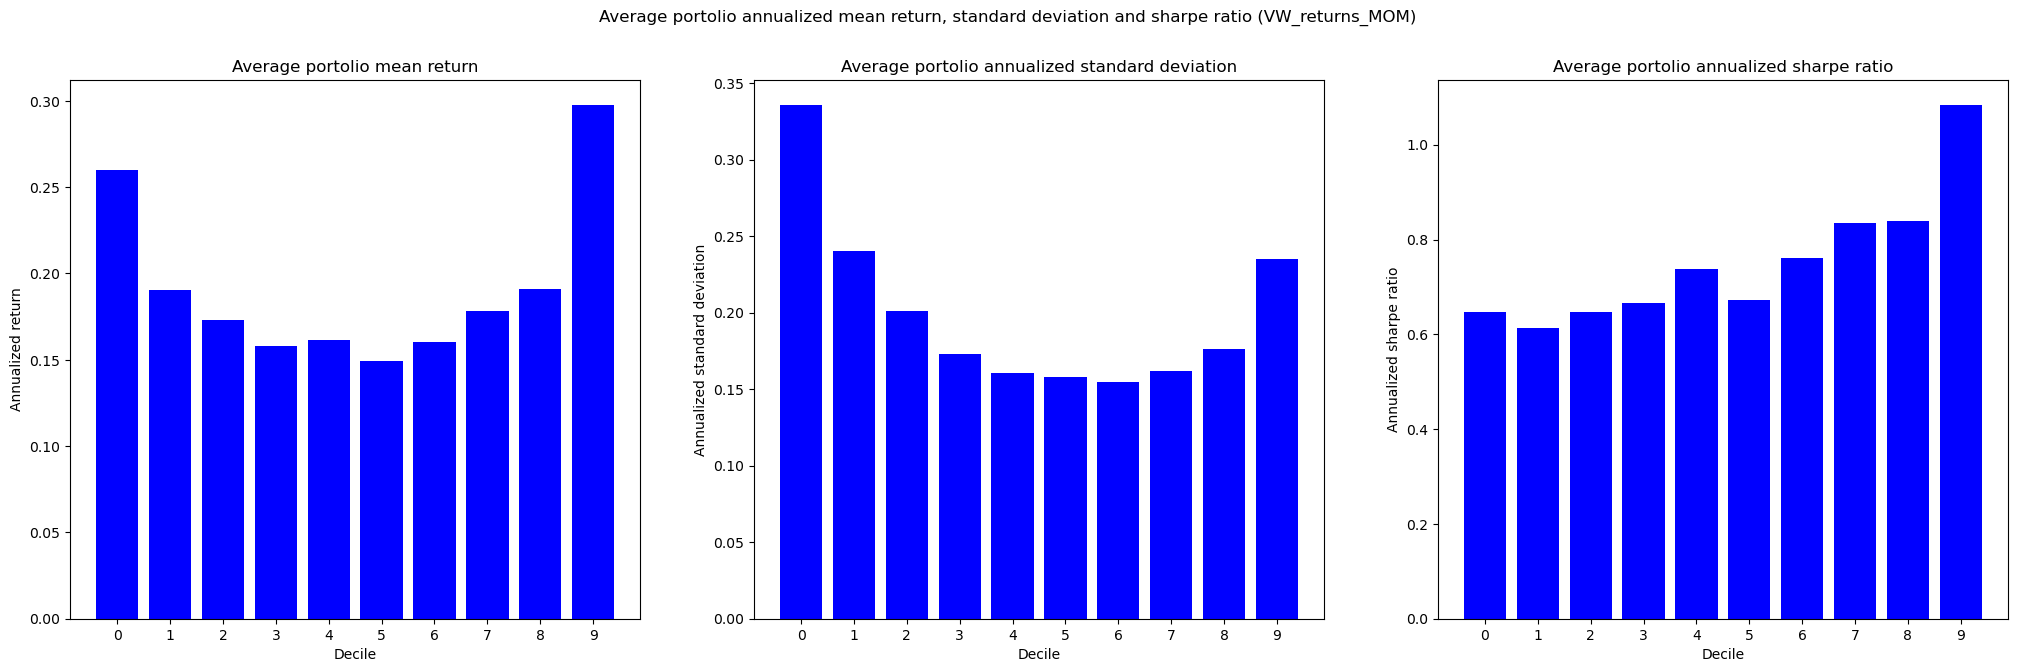

In [226]:
# Plot the results for the 2 different weightings
plot_mean_std_sr(EW_returns_mom, '4a', "EW_returns_MOM")
plot_mean_std_sr(VW_returns_mom, '4a', "VW_returns_MOM")

## Question b)

### Prepare data

In [227]:
# Create a column 'leg' that is 1 if the decile is 7, 8 or 9, and -1 if decile is 0, 1, 2
data_mom['leg'] = np.nan
data_mom.loc[data_mom['decile_mom'] <= 2, 'leg'] = -1
data_mom.loc[data_mom['decile_mom'] >= 7, 'leg'] = 1

# Drop the observations that are in none of the legs
data_mom_b = data_mom.dropna().copy()
display(data_mom_b)

,permno,date,ret,shrout,prc,siccd,mcap,mcap_l,tmytm,vwretd,Rn_e,Rm_e,roll_ret,decile_mom,EW_monthly_return,VW_weight,VW_ret_contrib,leg
85,10001,2011-01-31,0.028992,7834.0,10.78,4925,84450.52,86017.32,0.000125,0.019183,0.028867,0.019058,0.145569,2.0,0.027231,0.000063,1.839421e-06,-1.0
81,10001,2011-05-31,0.028050,8151.0,11.50,4925,93736.50,94144.05,0.000036,-0.014948,0.028014,-0.014984,0.105463,2.0,-0.017524,0.000054,1.513949e-06,-1.0
80,10001,2011-06-30,0.008261,8151.0,11.55,4925,94144.05,91128.18,0.000006,-0.018447,0.008255,-0.018453,0.128684,2.0,-0.018676,0.000055,4.560040e-07,-1.0
79,10001,2011-07-29,-0.028139,8151.0,11.18,4925,91128.18,89508.96,0.000074,-0.022534,-0.028213,-0.022608,0.053612,2.0,-0.030570,0.000053,-1.496899e-06,-1.0
66,10001,2012-08-31,-0.012315,8157.0,9.98,4925,81406.86,81080.58,0.000065,0.026317,-0.012380,0.026252,-0.026368,2.0,0.043579,0.000123,-1.519789e-06,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439275,93426,2023-05-31,-0.069792,12577.0,34.92,3676,439188.84,467235.55,0.004129,0.000708,-0.073921,-0.003421,0.270427,8.0,-0.023177,0.000156,-1.089036e-05,1.0
1439274,93426,2023-06-30,0.063860,12577.0,37.15,3676,467235.55,470505.57,0.004302,0.066183,0.059558,0.061881,0.242411,7.0,0.112128,0.000166,1.059465e-05,1.0
1439273,93426,2023-07-31,0.006999,12577.0,37.41,3676,470505.57,453167.62,0.004442,0.035624,0.002557,0.031182,0.235897,7.0,0.038200,0.000162,1.131344e-06,1.0
1439269,93426,2023-11-30,0.019051,12510.0,30.49,3676,381429.90,426215.70,0.004455,0.092057,0.014596,0.087602,-0.276471,2.0,0.084776,0.000199,3.791824e-06,-1.0


### Equally weighted portfolios

In [228]:
# Create a dataframe that aggregates takes the average return for each leg, at each month. Also keep the risk free rate
EW_data_mom = data_mom_b.groupby(['date', 'leg']).agg({
    'ret': 'mean', 
    RF_COL: 'first',
    }).reset_index()

EW_data_mom_piv = EW_data_mom.pivot(index='date', columns='leg', values='ret') # Pivot the data
EW_data_mom_piv['EW_return'] = EW_data_mom_piv[1] - EW_data_mom_piv[-1] # Compute the return of the EW momentum strategy as being the difference between the two legs
EW_data_mom_piv[RF_COL] = EW_data_mom.groupby('date')[RF_COL].first() # Add the risk free rate
EW_data_mom_piv = EW_data_mom_piv[['EW_return', RF_COL]]   # Keep only the relevant columns
# display(EW_data_mom_piv)

# Compute mean, std and Sharpe ratio
mean = EW_data_mom_piv['EW_return'].mean() * 12
std = EW_data_mom_piv['EW_return'].std() * np.sqrt(12)
rf = EW_data_mom_piv[RF_COL].mean() * 12

# Dispay the results
print(colored("Momentum strategy based on equally weighted portfolios", "blue", attrs=['underline', 'bold']))
print(" - Expected return:\t {:.2f}%".format(mean))
print(" - Standard deviation:\t {:.2f}%".format(std))
print(" - Sharpe ratio:\t {:.2f}".format((mean - rf)/ std))

Momentum strategy based on equally weighted portfolios
 - Expected return:	 0.03%
 - Standard deviation:	 0.17%
 - Sharpe ratio:	 -0.11


###  Value weighted portfolios

In [229]:
VW_data_mom = data_mom_b.copy()

VW_data_mom['VW_wL'] = (VW_data_mom['leg'] == -1) * VW_data_mom['mcap']
VW_data_mom['VW_wL_sum'] = VW_data_mom.groupby('date')['VW_wL'].transform('sum')
VW_data_mom['VW_wH'] = (VW_data_mom['leg'] == 1) * VW_data_mom['mcap']
VW_data_mom['VW_wH_sum'] = VW_data_mom.groupby('date')['VW_wH'].transform('sum')
VW_data_mom['VW_wL'] = VW_data_mom['VW_wL'] / VW_data_mom['VW_wL_sum']
VW_data_mom['VW_wH'] = VW_data_mom['VW_wH'] / VW_data_mom['VW_wH_sum']
VW_data_mom = VW_data_mom.drop(columns=['VW_wL_sum', 'VW_wH_sum'])
VW_data_mom['VW_w'] = VW_data_mom['VW_wL'] * VW_data_mom['leg'] + VW_data_mom['VW_wH'] * VW_data_mom['leg']
VW_data_mom['VW_ret'] = VW_data_mom['VW_w'] * VW_data_mom['ret']


# Create a dataframe that aggregates the returns, at each month and keep the risk free rate
VW_data_mom_ = VW_data_mom.groupby(['date']).agg({
    'VW_ret': 'sum', 
    RF_COL: 'first',
    }).reset_index()

# display(VW_data_mom_)

# Compute mean, std and Sharpe ratio
mean = VW_data_mom_['VW_ret'].mean() * 12
std = VW_data_mom_['VW_ret'].std() * np.sqrt(12)
rf = VW_data_mom_[RF_COL].mean() * 12

# Dispay the results
print(colored("Momentum strategy based on value weighted portfolios", "blue", attrs=['underline', 'bold']))
print(" - Expected return:\t {:.2f}%".format(mean))
print(" - Standard deviation:\t {:.2f}%".format(std))
print(" - Sharpe ratio:\t {:.2f}".format((mean - rf)/ std))

Momentum strategy based on value weighted portfolios
 - Expected return:	 0.01%
 - Standard deviation:	 0.18%
 - Sharpe ratio:	 -0.18


# 5 Idiosyncratic Volatility Strategy (IV)

## Prepare data

In [230]:
data_iv = data_Qb.drop(columns=['VW_weight', 'VW_ret_contrib', 'mcap_l', 'EW_monthly_decile']).copy()
display(data_iv.head())
print(data_iv.shape)

,permno,date,ret,shrout,prc,siccd,mcap,tmytm,vwretd,Rn_e,Rm_e,beta
36,10001,2013-01-31,0.062701,8157.0,9.87,4925,80509.59,0.000051,0.054142,0.062650,0.054091,2.152012
37,10001,2013-02-28,0.011651,8157.0,9.94,4925,81080.58,0.000040,0.008282,0.011611,0.008242,2.064342
38,10001,2013-03-28,0.030684,8157.0,10.20,4925,83201.40,0.000034,0.035295,0.030650,0.035261,2.065339
44,10001,2013-09-30,0.004412,10372.0,10.20,4925,105794.40,0.000017,0.037497,0.004395,0.037480,2.084554
48,10001,2014-01-31,0.147572,10452.0,9.17,4925,95844.84,0.000042,-0.030020,0.147530,-0.030062,2.327879


(403329, 12)


## Question a)

Use previously computed rolling betas to compute the residuals of the regression of the stock's excess return against market excess return

⚠️ Je suis pas sur que ce soit la bonne manière puisque les betas sont calculés sur une rolling window déjà, mais on recalcule l'écart type des résidus sur une rolling window (rolling de rolling??)

In [231]:
# Residuals
data_iv['residuals'] = data_iv['Rn_e'] - (data_iv['beta'] * data_iv['Rm_e'])

# Compute volatility of residuals (idiosyncratic volatility)
data_iv['IV'] = data_iv.groupby('permno')['residuals'].rolling(window=w, min_periods=36).std().reset_index(level=0, drop=True)
data_iv = data_iv.dropna(subset=['IV']).copy()

# Winsorize at 5% and 95% (code from PS5)
data_iv['IV'] = data_iv['IV'].clip(data_iv['IV'].quantile(0.05), data_iv['IV'].quantile(0.95))

data_iv = data_iv.drop(columns=['residuals']) # no need that column anymore

display(data_iv.head())
print(data_iv.shape)

,permno,date,ret,shrout,prc,siccd,mcap,tmytm,vwretd,Rn_e,Rm_e,beta,IV
236,10006,1976-04-30,0.012658,5783.0,50.000,3743,289150.000,0.003911,-0.010402,0.008747,-0.014313,0.878247,0.064114
239,10006,1976-07-30,-0.052265,8675.0,34.000,3743,294950.000,0.004235,-0.006136,-0.056500,-0.010371,0.888217,0.063593
241,10006,1976-09-30,0.040892,8675.0,35.000,3743,303625.000,0.004235,0.024513,0.036657,0.020278,0.918600,0.062853
245,10006,1977-01-31,0.014235,8675.0,35.625,3743,309046.875,0.003793,-0.036326,0.010442,-0.040119,0.894098,0.062580
246,10006,1977-02-28,-0.022456,8675.0,34.375,3743,298203.125,0.003691,-0.015744,-0.026147,-0.019435,0.899216,0.061776


(223996, 13)


## Question b)

In [232]:
# Create deciles based on IV
data_iv["IV_decile"] = data_iv.groupby("date")["IV"].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

### Equally weighted

In [233]:
# Equally weighted returns per month, for each decile
EW_returns_IV = data_iv.groupby(["date", "IV_decile"]).agg({
    'date': 'first',
    'ret': 'mean',
    RF_COL: 'first',
    'IV_decile': 'first'
    }).reset_index(drop=True).rename(columns={'IV_decile': 'decile'})

print(colored("Equally weighted monthly returns per decile, IV:", "blue", attrs=['underline', 'bold']))
display(EW_returns_IV.head(5))
print(EW_returns_IV.shape)

Equally weighted monthly returns per decile, IV:


,date,ret,tmytm,decile
0,1976-04-30,-0.001292,0.003911,0
1,1976-04-30,-0.007008,0.003911,1
2,1976-04-30,0.000118,0.003911,2
3,1976-04-30,-0.011900,0.003911,3
4,1976-04-30,-0.012108,0.003911,4


(2089, 4)


### Value weighted

In [234]:
# Value weighted returns per month, for each decile
data_iv['VW_weight'] = data_iv.groupby(['date', 'IV_decile'])['mcap'].transform(lambda x: x / x.sum())
data_iv['VW_ret_contrib'] = data_iv['VW_weight'] * data_iv['ret']

VW_returns_IV = data_iv.groupby(["date", "IV_decile"]).agg({
    'date': 'first',
    'VW_ret_contrib': 'sum',
    RF_COL: 'first',
    'IV_decile': 'first',
    }).reset_index(drop=True).rename(columns={'IV_decile': 'decile', 'VW_ret_contrib': 'ret'})

print(colored("Value weighted monthly returns per decile, IV:", "blue", attrs=['underline', 'bold']))
display(VW_returns_IV.head(5))
print(VW_returns_IV.shape)

Value weighted monthly returns per decile, IV:


,date,ret,tmytm,decile
0,1976-04-30,-0.010283,0.003911,0
1,1976-04-30,-0.001537,0.003911,1
2,1976-04-30,-0.006088,0.003911,2
3,1976-04-30,0.004725,0.003911,3
4,1976-04-30,-0.001755,0.003911,4


(2089, 4)


### Plot the mean, std, sr

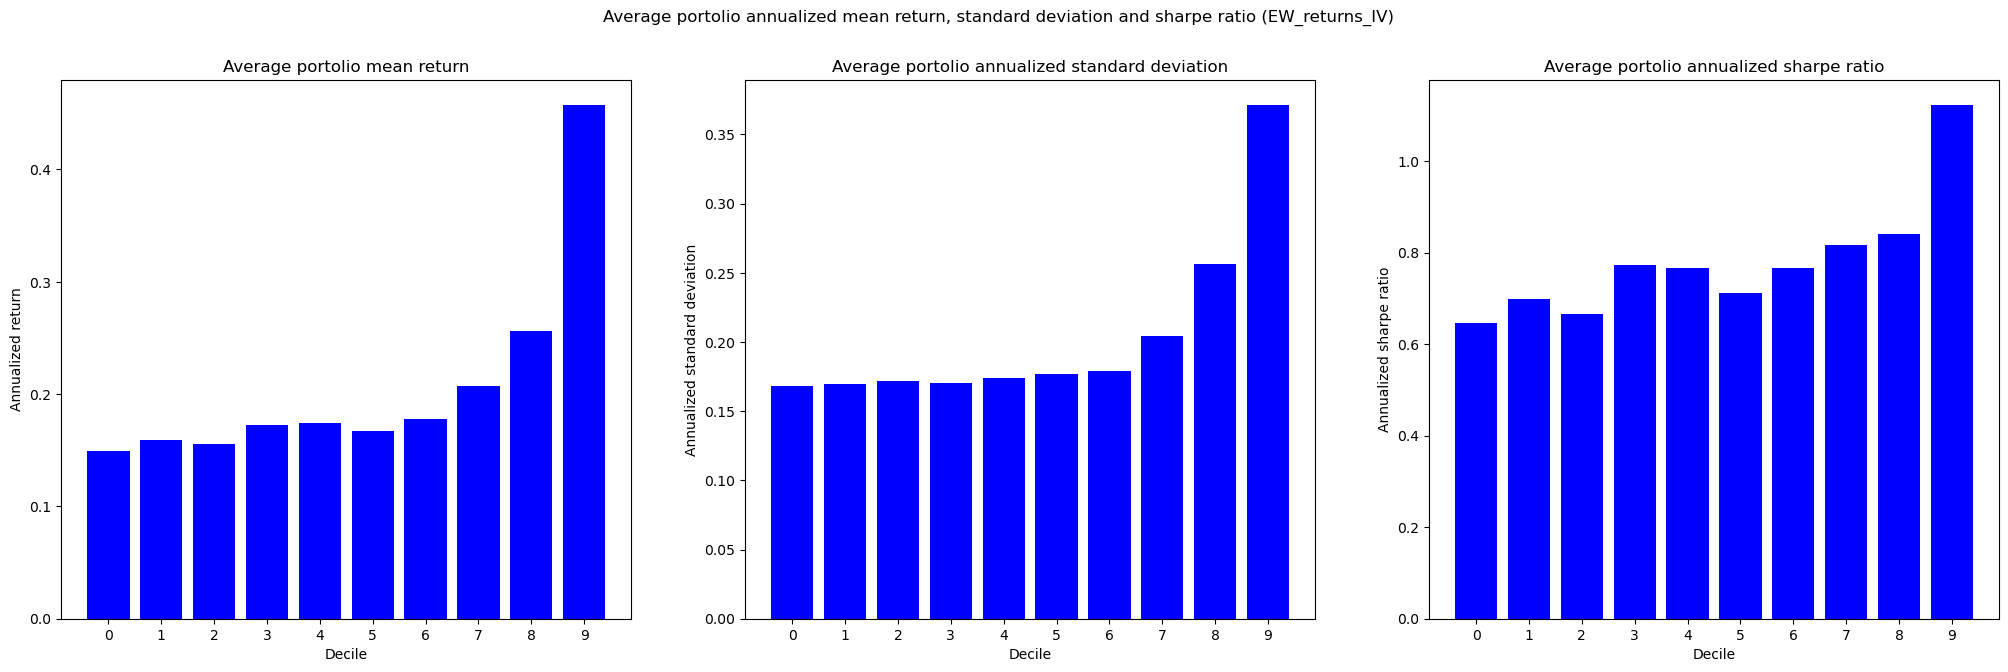

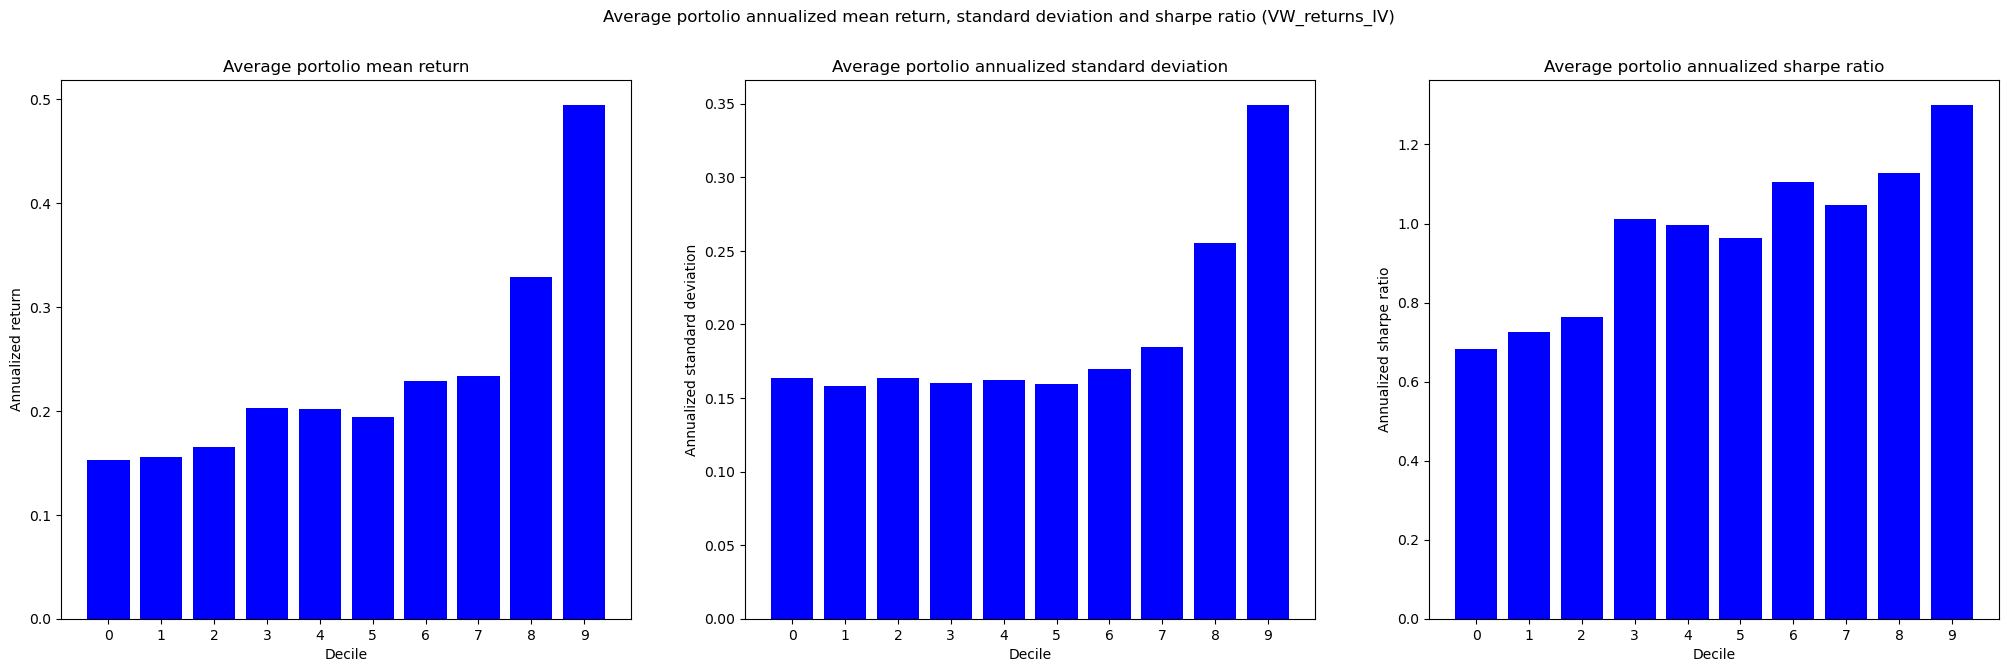

In [235]:
# Plot the results for the 2 different weightings
plot_mean_std_sr(EW_returns_IV, '5b', "EW_returns_IV")
plot_mean_std_sr(VW_returns_IV, '5b', "VW_returns_IV")

## Question c)

### Prepare data

In [236]:
# Create a column 'leg' that is 1 if the decile is 7, 8 or 9, and -1 if decile is 0, 1, 2
data_iv['leg'] = np.nan
data_iv.loc[data_iv['IV_decile'] <= 2, 'leg'] = -1
data_iv.loc[data_iv['IV_decile'] >= 7, 'leg'] = 1

# Drop the observations that are in none of the legs
data_iv_c = data_iv.dropna().copy()

display(data_iv_c.head())
print(data_iv_c.shape)

,permno,date,ret,shrout,prc,siccd,mcap,tmytm,vwretd,Rn_e,Rm_e,beta,IV,IV_decile,VW_weight,VW_ret_contrib,leg
236,10006,1976-04-30,0.012658,5783.0,50.000,3743,289150.000,0.003911,-0.010402,0.008747,-0.014313,0.878247,0.064114,1,0.002500,0.000032,-1.0
239,10006,1976-07-30,-0.052265,8675.0,34.000,3743,294950.000,0.004235,-0.006136,-0.056500,-0.010371,0.888217,0.063593,1,0.002419,-0.000126,-1.0
241,10006,1976-09-30,0.040892,8675.0,35.000,3743,303625.000,0.004235,0.024513,0.036657,0.020278,0.918600,0.062853,1,0.003541,0.000145,-1.0
245,10006,1977-01-31,0.014235,8675.0,35.625,3743,309046.875,0.003793,-0.036326,0.010442,-0.040119,0.894098,0.062580,0,0.000972,0.000014,-1.0
246,10006,1977-02-28,-0.022456,8675.0,34.375,3743,298203.125,0.003691,-0.015744,-0.026147,-0.019435,0.899216,0.061776,0,0.000950,-0.000021,-1.0


(134501, 17)


### Equally weighted portfolios

First, compare the performance of each leg

,leg,ret,tmytm
0,-1.0,0.048595,0.003387
1,1.0,0.075775,0.003387


Equally weighted monthly returns per leg, IV:
Leg =  1 if decile is 7, 8, 9 
Leg = -1 if decile is 0, 1, 2


,date,ret,tmytm,leg
0,1976-04-30,-0.002723,0.003911,-1.0
1,1976-04-30,-0.033160,0.003911,1.0
2,1976-07-30,0.001648,0.004235,-1.0
3,1976-07-30,-0.007155,0.004235,1.0
4,1976-09-30,0.020883,0.004235,-1.0


(422, 4)


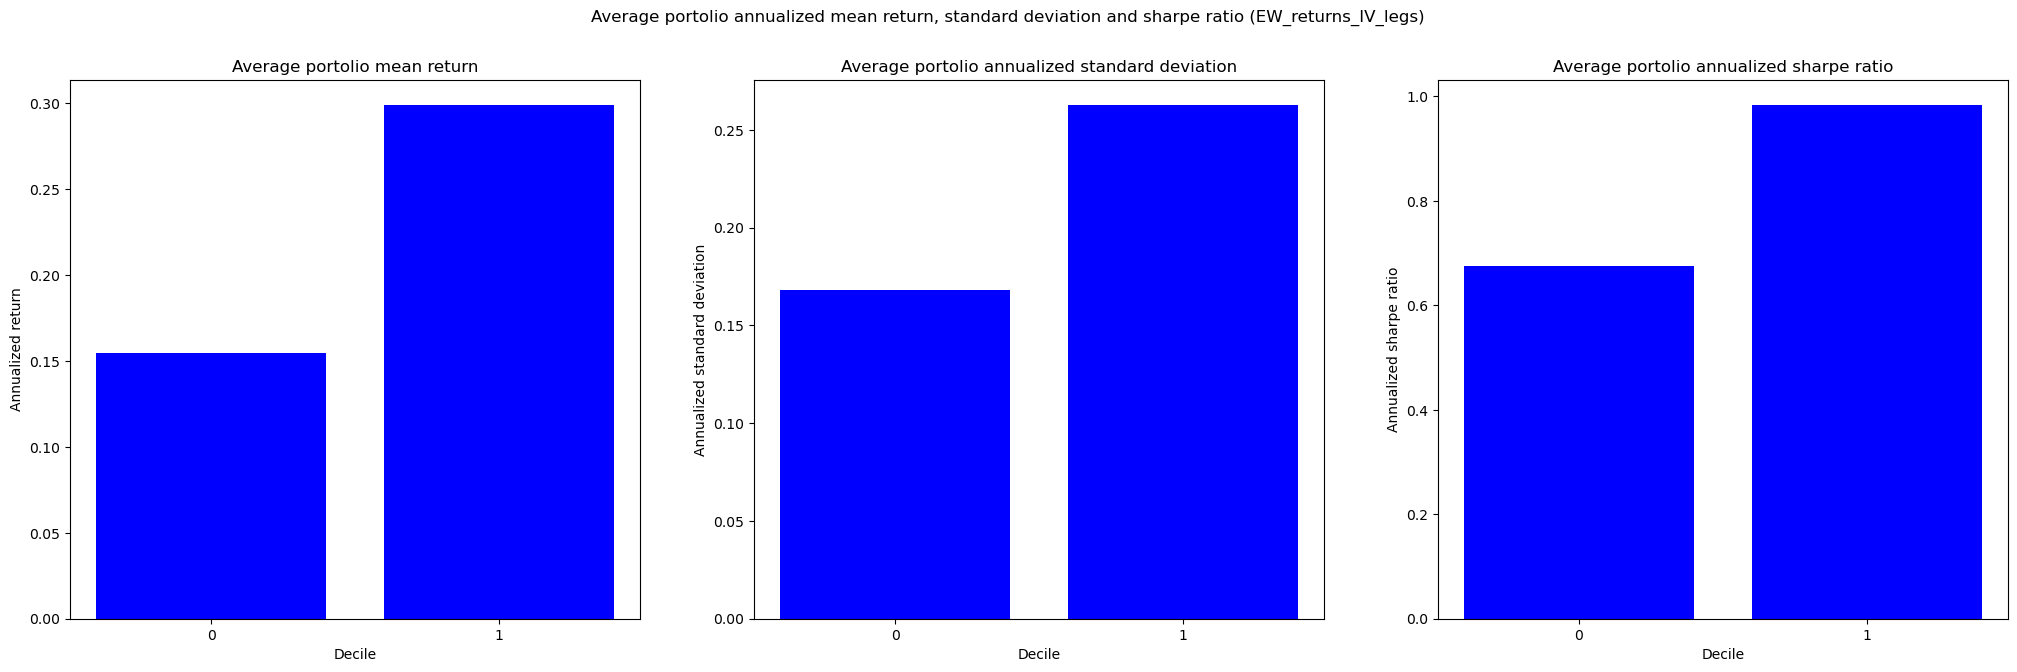

In the graph, leg '-1' corresponds to bar '0'; leg '1' is bar '1'.


In [237]:
# Compare the performance of each leg
EW_returns_IV_legs = data_iv_c.groupby(["date", "leg"]).agg({
    'date': 'first',
    'ret': 'mean',
    RF_COL: 'first',
    'leg': 'first'
    }).reset_index(drop=True)

testons = EW_returns_IV_legs.groupby('leg').agg({
    'ret': 'std',
    RF_COL: 'mean'
    }).reset_index()
display(testons)

print(colored("Equally weighted monthly returns per leg, IV:", "blue", attrs=['underline', 'bold']))
print("Leg =  1 if decile is 7, 8, 9 \nLeg = -1 if decile is 0, 1, 2")
display(EW_returns_IV_legs.head(5))
print(EW_returns_IV_legs.shape)

# Plot the mean, std, sr
plot_mean_std_sr(EW_returns_IV_legs.rename(columns={'leg': 'decile'}), '5c', "EW_returns_IV_legs")
print("In the graph, leg '-1' corresponds to bar '0'; leg '1' is bar '1'.")

Second, display the performance

In [238]:
# Create a dataframe that aggregates takes the average return for each leg, at each month. Also keep the risk free rate
EW_data_IV_leg = data_iv_c.groupby(['date', 'leg']).agg({
    'ret': 'mean', 
    RF_COL: 'first',
    }).reset_index()

EW_data_IV_piv = EW_data_IV_leg.pivot(index='date', columns='leg', values='ret') # Pivot the data
EW_data_IV_piv['EW_return'] = EW_data_IV_piv[1] - EW_data_IV_piv[-1] # Compute the return of the EW momentum strategy as being the difference between the two legs
EW_data_IV_piv[RF_COL] = EW_data_IV_leg.groupby('date')[RF_COL].first() # Add the risk free rate
EW_data_IV_piv = EW_data_IV_piv[['EW_return', RF_COL]]   # Keep only the relevant columns

# Compute mean, std and Sharpe ratio
mean_EW_IV = EW_data_IV_piv['EW_return'].mean() * 12
std_EW_IV = EW_data_IV_piv['EW_return'].std() * np.sqrt(12)
rf_EW_IV = EW_data_IV_piv[RF_COL].mean() * 12

# Dispay the results
print(colored("Momentum strategy based on equally weighted portfolios", "blue", attrs=['underline', 'bold']))
print(" - Expected return:\t {:.2f}".format(mean_EW_IV))
print(" - Standard deviation:\t {:.2f}".format(std_EW_IV))
print(" - Sharpe ratio:\t {:.2f}".format((mean_EW_IV - rf_EW_IV)/ std_EW_IV))

Momentum strategy based on equally weighted portfolios
 - Expected return:	 0.14
 - Standard deviation:	 0.16
 - Sharpe ratio:	 0.65


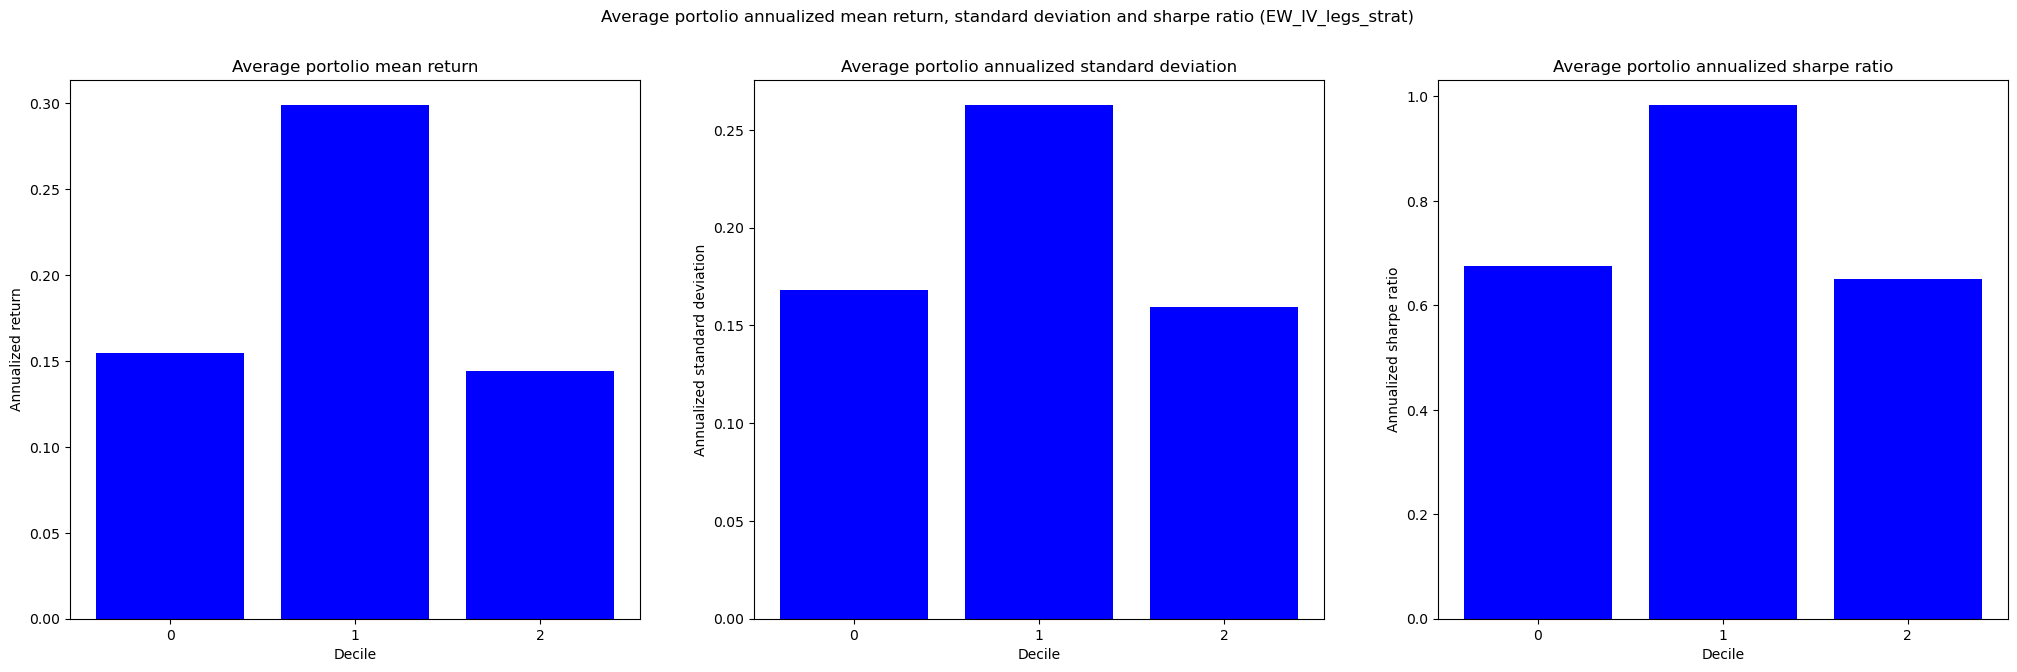

Bar 0: leg -1; Bar 1: leg 1; Bar 2: Strategy


In [239]:
# Compare the 2 legs and the strategy in a graph
mean, std, sr = get_mean_std_sharpe(EW_returns_IV_legs.rename(columns={'leg': 'decile'}))
mean.append(mean_EW_IV), std.append(std_EW_IV), sr.append((mean_EW_IV - rf_EW_IV)/ std_EW_IV)
# print(mean, std, sr)

plot = plot_from_lists(mean, std, sr, plot_color = 'blue')

plot.suptitle(f'Average portolio annualized mean return, standard deviation and sharpe ratio (EW_IV_legs_strat)')
plot.savefig(f"Figures/question_5c_plot_EW_IV_legs_strat")
plot.show()
print("Bar 0: leg -1; Bar 1: leg 1; Bar 2: Strategy")

### Value weighted portfolios

First, compare the performance of each leg.

,date,leg,ret,tmytm
0,1976-04-30,-1.0,-0.017908,0.003911
1,1976-04-30,1.0,-0.083616,0.003911
2,1976-07-30,-1.0,-0.009339,0.004235
3,1976-07-30,1.0,-0.053053,0.004235
4,1976-09-30,-1.0,0.089875,0.004235
...,...,...,...,...
417,2023-06-30,1.0,0.231515,0.004302
418,2023-08-31,-1.0,-0.072920,0.004463
419,2023-08-31,1.0,0.071554,0.004463
420,2023-11-30,-1.0,0.260227,0.004455


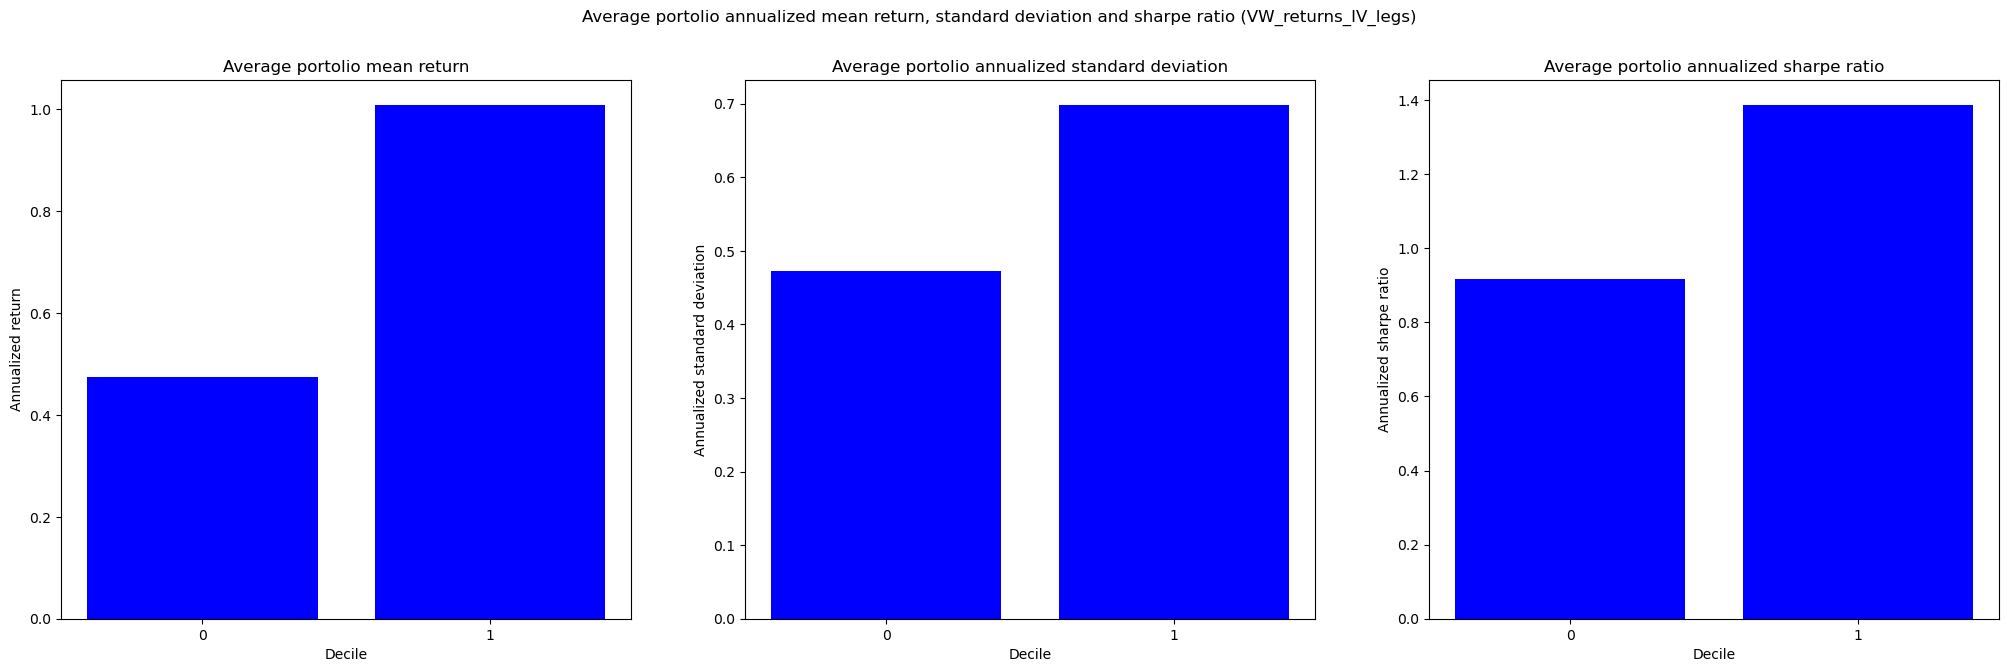

In the graph, leg '-1' corresponds to bar '0'; leg '1' is bar '1'.


In [240]:
# Re-use the dataframe from earlier question, we already computed the VW contribution
VW_data_IV = data_iv_c.copy()

VW_returns_IV_legs = VW_data_IV.groupby(['date', 'leg']).agg({
    'VW_ret_contrib': 'sum', 
    RF_COL: 'first',
    }).rename(columns={'VW_ret_contrib': 'ret'}).reset_index()

display(VW_returns_IV_legs)

# Plot the mean, std, sr
plot_mean_std_sr(VW_returns_IV_legs.rename(columns={'leg': 'decile'}), '5c', "VW_returns_IV_legs")
print("In the graph, leg '-1' corresponds to bar '0'; leg '1' is bar '1'.")

leg,VW_return,tmytm
date,,
1976-04-30,-0.065708,0.003911
1976-07-30,-0.043714,0.004235
1976-09-30,-0.013948,0.004235
1977-01-31,0.249643,0.003793
1977-02-28,0.031389,0.003691
...,...,...
2022-12-30,-0.027612,0.003326
2023-02-28,0.041189,0.003682
2023-06-30,0.007967,0.004302


Momentum strategy based on value weighted portfolios
 - Expected return:	 0.53
 - Standard deviation:	 0.44
 - Sharpe ratio:	 1.13


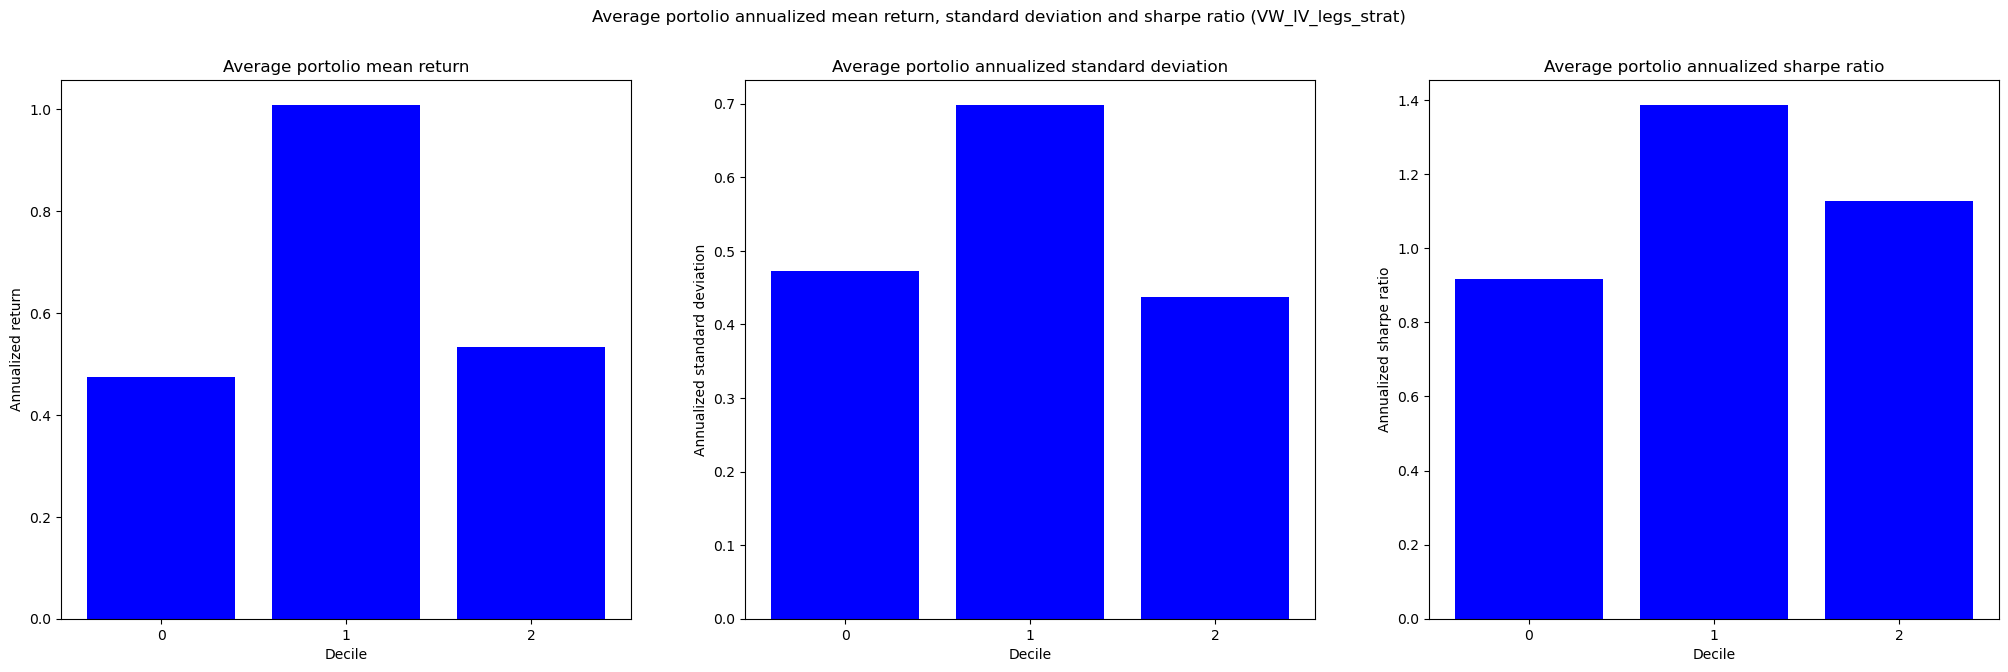

Bar 0: leg -1; Bar 1: leg 1; Bar 2: Strategy


In [241]:
# We use the same methodolgy as before to compute the return of the strategy
VW_data_IV_piv = VW_returns_IV_legs.pivot(index='date', columns='leg', values='ret') # Pivot the data
VW_data_IV_piv['VW_return'] = VW_data_IV_piv[1] - VW_data_IV_piv[-1] # Compute the return of the EW momentum strategy as being the difference between the two legs
VW_data_IV_piv[RF_COL] = VW_returns_IV_legs.groupby('date')[RF_COL].first() # Add the risk free rate
VW_data_IV_piv = VW_data_IV_piv[['VW_return', RF_COL]]   # Keep only the relevant columns
display(VW_data_IV_piv)

# Compute mean, std and Sharpe ratio
mean_VW_IV = VW_data_IV_piv['VW_return'].mean() * 12
std_VW_IV = VW_data_IV_piv['VW_return'].std() * np.sqrt(12)
rf_VW_IV = VW_data_IV_piv[RF_COL].mean() * 12

# Dispay the results
print(colored("Momentum strategy based on value weighted portfolios", "blue", attrs=['underline', 'bold']))
print(" - Expected return:\t {:.2f}".format(mean_VW_IV))
print(" - Standard deviation:\t {:.2f}".format(std_VW_IV))
print(" - Sharpe ratio:\t {:.2f}".format((mean_VW_IV - rf_VW_IV)/ std_VW_IV))

# Compare the 2 legs and the strategy in a graph
mean, std, sr = get_mean_std_sharpe(VW_returns_IV_legs.rename(columns={'leg': 'decile'}))
mean.append(mean_VW_IV), std.append(std_VW_IV), sr.append((mean_VW_IV - rf_VW_IV)/ std_VW_IV)
# print(mean, std, sr)

plot = plot_from_lists(mean, std, sr, plot_color = 'blue')

plot.suptitle(f'Average portolio annualized mean return, standard deviation and sharpe ratio (VW_IV_legs_strat)')
plot.savefig(f"Figures/question_5c_plot_VW_IV_legs_strat")
plot.show()
print("Bar 0: leg -1; Bar 1: leg 1; Bar 2: Strategy")

# 6 Optimal Fund Portfolio Return (STRAT)

We only consider the value weighted portfolios from the previous strategies.

In [242]:
VOL_TARGET = 0.1

## Prepare data

In [243]:
# First we prepare the data
dataBAB = data_BAB[['date', 'rBAB']].copy()
dataMOM = VW_data_mom_[['date', 'VW_ret', RF_COL]].rename(columns={'VW_ret':'rMOM'}).copy()
dataIV = VW_data_IV_piv.rename(columns={'VW_return':'rIV'}).copy().reset_index()

In [244]:
# Merge the data
dataSTRAT = pd.merge(dataBAB, dataMOM, on='date', how='inner')
dataSTRAT = pd.merge(dataSTRAT, dataIV[['date', 'rIV']], on='date', how='inner')
dataSTRAT= dataSTRAT[['date', RF_COL, 'rBAB', 'rMOM', 'rIV']]
display(dataSTRAT.head())
print(dataSTRAT.shape)

,date,tmytm,rBAB,rMOM,rIV
0,1976-04-30,0.003911,-0.076296,-0.005513,-0.065708
1,1976-07-30,0.004235,-0.041801,-0.013360,-0.043714
2,1976-09-30,0.004235,0.025894,-0.001556,-0.013948
3,1977-01-31,0.003793,0.040469,0.067093,0.249643
4,1977-02-28,0.003691,-0.036342,-0.017705,0.031389


(211, 5)


In [245]:
# Function to compute the mean, std and Sharpe ratio of the STRAT strategies
def get_mean_std_sharpe_STRAT(data, return_col:str):
    mean = data[return_col].mean() * 12
    std = data[return_col].std() * np.sqrt(12)
    rf = data[RF_COL].mean() * 12
    sr = (mean - rf) / std
    return mean, std, sr

## Equal weight strategies

The return of STRAT is the the weighted average of the returns of the 3 strategies

In [246]:
# Compute the STRAT return
dataSTRAT_EW = dataSTRAT.copy()
dataSTRAT_EW['rSTRAT_EW'] = (dataSTRAT_EW['rBAB'] + dataSTRAT_EW['rMOM'] + dataSTRAT_EW['rIV']) / 3
dataSTRAT_EW.head()

,date,tmytm,rBAB,rMOM,rIV,rSTRAT_EW
0,1976-04-30,0.003911,-0.076296,-0.005513,-0.065708,-0.049172
1,1976-07-30,0.004235,-0.041801,-0.013360,-0.043714,-0.032958
2,1976-09-30,0.004235,0.025894,-0.001556,-0.013948,0.003463
3,1977-01-31,0.003793,0.040469,0.067093,0.249643,0.119068
4,1977-02-28,0.003691,-0.036342,-0.017705,0.031389,-0.007553


In [247]:
# Determining the c constant for each year
dataSTRAT_EW['rSTRATstd'] = dataSTRAT_EW.groupby(dataSTRAT_EW.date.dt.year)['rSTRAT_EW'].transform('std') * np.sqrt(12)
dataSTRAT_EW['C'] = 0.1 / dataSTRAT_EW['rSTRATstd']
dataSTRAT_EW['rFUND_EW'] = dataSTRAT_EW['C'] * dataSTRAT_EW['rSTRAT_EW'] + dataSTRAT_EW[RF_COL]

display(dataSTRAT_EW.head())
print(dataSTRAT_EW.shape)

,date,tmytm,rBAB,rMOM,rIV,rSTRAT_EW,rSTRATstd,C,rFUND_EW
0,1976-04-30,0.003911,-0.076296,-0.005513,-0.065708,-0.049172,0.093381,1.070885,-0.048747
1,1976-07-30,0.004235,-0.041801,-0.013360,-0.043714,-0.032958,0.093381,1.070885,-0.031060
2,1976-09-30,0.004235,0.025894,-0.001556,-0.013948,0.003463,0.093381,1.070885,0.007944
3,1977-01-31,0.003793,0.040469,0.067093,0.249643,0.119068,0.203935,0.490353,0.062178
4,1977-02-28,0.003691,-0.036342,-0.017705,0.031389,-0.007553,0.203935,0.490353,-0.000013


(211, 9)


In [267]:
retSTRAT_EW, stdSTRAT_EW, srSTRAT_EW = get_mean_std_sharpe_STRAT(dataSTRAT_EW, 'rFUND_EW')

print(colored("STRAT strategy based on equally weighted portfolios", attrs=['underline', 'bold'])) 
print(" - Expected return:\t {:.2f}".format(retSTRAT_EW))
print(" - Standard deviation:\t {:.2f}".format(stdSTRAT_EW))
print(" - Sharpe ratio:\t {:.2f}".format(srSTRAT_EW))

STRAT strategy based on equally weighted portfolios
 - Expected return:	 0.21
 - Standard deviation:	 0.13
 - Sharpe ratio:	 1.29


# Risk-parity based approach

## Part a)

We determine the weights of BAB, MOM, IV under a risk parity approach, based on the rolling estimate of their return std over the last 36 months (excluding last).

In [250]:
# For the risk parity, we use the rolling 3-year monthly volatility
dataSTRAT_RP = dataSTRAT.copy()

dataSTRAT_RP['rBABstd'] = dataSTRAT_RP['rBAB'].rolling(window=36, min_periods=36, closed='left').std() * np.sqrt(12)
dataSTRAT_RP['rMOMstd'] = dataSTRAT_RP['rMOM'].rolling(window=36, min_periods=36, closed='left').std() * np.sqrt(12)
dataSTRAT_RP['rIVstd'] = dataSTRAT_RP['rIV'].rolling(window=36, min_periods=36, closed='left').std()   * np.sqrt(12)
dataSTRAT_RP.dropna(inplace=True)

dataSTRAT_RP['rSTRAT'] = dataSTRAT_RP['rBAB']/dataSTRAT_RP['rBABstd'] + dataSTRAT_RP['rMOM']/dataSTRAT_RP['rMOMstd'] + dataSTRAT_RP['rIV']/dataSTRAT_RP['rIVstd']

dataSTRAT_RP['rSTRATstd'] = dataSTRAT_RP.groupby(dataSTRAT_RP.date.dt.year)['rSTRAT'].transform('std') * np.sqrt(12)
dataSTRAT_RP['C'] = 0.1 / dataSTRAT_RP['rSTRATstd']
dataSTRAT_RP['rFUND_RP'] = dataSTRAT_RP['C'] * dataSTRAT_RP['rSTRAT'] + dataSTRAT_RP[RF_COL]

retSTRAT_RP, stdSTRAT_RP, srSTRAT_RP = get_mean_std_sharpe_STRAT(dataSTRAT_RP, 'rFUND_RP')

print(colored("STRAT strategy based on equally risk parity portfolios", attrs=['underline', 'bold'])) 
print(" - Expected return:\t {:.2f}".format(retSTRAT_RP))
print(" - Standard deviation:\t {:.2f}".format(stdSTRAT_RP))
print(" - Sharpe ratio:\t {:.2f}".format(srSTRAT_RP))

,date,tmytm,rBAB,rMOM,rIV,rBABstd,rMOMstd,rIVstd,rSTRAT,rSTRATstd,C,rFUND_RP
36,1984-02-29,0.007408,-0.078853,0.033062,-0.070728,0.284038,0.135282,0.382138,-0.218308,1.244051,0.080383,-0.010140
37,1984-04-30,0.007719,-0.033634,0.008291,-0.002719,0.284368,0.135018,0.382840,-0.063973,1.244051,0.080383,0.002577
38,1984-08-31,0.008933,0.195877,-0.087902,0.116067,0.283707,0.133922,0.378727,0.340526,1.244051,0.080383,0.036305
39,1984-11-30,0.006172,-0.079454,-0.001543,-0.092318,0.299509,0.146817,0.374045,-0.522603,1.244051,0.080383,-0.035836
40,1985-01-31,0.006377,0.195111,-0.072748,0.205766,0.306565,0.143818,0.376850,0.676627,2.003851,0.049904,0.040143
...,...,...,...,...,...,...,...,...,...,...,...,...
206,2022-12-30,0.003326,-0.101007,0.025262,-0.027612,0.593937,0.192588,0.413028,-0.105745,1.804679,0.055412,-0.002533
207,2023-02-28,0.003682,-0.051217,0.004243,0.041189,0.599032,0.192727,0.414108,0.035981,1.181429,0.084643,0.006728
208,2023-06-30,0.004302,0.189069,0.040903,0.007967,0.600353,0.192364,0.413402,0.546833,1.181429,0.084643,0.050588
209,2023-08-31,0.004463,-0.094532,0.048052,0.144474,0.606938,0.188434,0.413283,0.448828,1.181429,0.084643,0.042454


STRAT strategy based on equally risk parity portfolios
 - Expected return:	 0.17
 - Standard deviation:	 0.13
 - Sharpe ratio:	 1.09


## Performance and risk analysis for the Fund strategy

We need to load the data from the 12 industry portfolio return and the Fama/French 5 factors

In [251]:
famafrench = pd.read_csv("Data/F-F_Research_Data_5_Factors_2x3.CSV", skiprows=3) 
#Industry_weights_12 = pd.read_csv("Data/12_Industry_Portfolios.CSV", skiprows=11)
# Load the entire CSV file
with open("Data/12_Industry_Portfolios.CSV", 'r') as file:
    lines = file.readlines()

# Find the start and end of the first table
start_index = None
end_index = None
for i, line in enumerate(lines):
    if 'Average Value Weighted Returns -- Monthly' in line:
        start_index = i + 1  # The data starts after this line
    elif start_index is not None and line.strip() == '':
        end_index = i
        break

# Extract the lines for the first table
table_lines = lines[start_index:end_index]

# Create a new DataFrame from the extracted lines
Industry_weights_12 = pd.DataFrame([x.strip().split(',') for x in table_lines[1:]], columns=table_lines[0].strip().split(','))

# Convert appropriate columns to numeric
Industry_weights_12 = Industry_weights_12.apply(pd.to_numeric, errors='ignore')
with open("Data/Siccodes12.txt", 'r') as file:
    Industries = file.read()

/var/folders/m_/yzdwm7r920v1q2nq85qbp92r0000gn/T/ipykernel_1168/913572597.py:24: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  Industry_weights_12 = Industry_weights_12.apply(pd.to_numeric, errors='ignore')


In [252]:
import re
# Regular expression to match each class and its indices
pattern = r'(\d+)\s+(\w+)\s+([^\n]+)\n((?:\s+\d+-\d+\n?)+)'

# Find all matches in the content
matches = re.findall(pattern, Industries)

# Initialize an empty dictionary to hold the classes and their indices
classes = {}

# Iterate over each match and populate the dictionary
for match in matches:
    class_number = int(match[0])
    class_code = match[1]
    class_description = match[2].strip()
    indices_raw = match[3].strip().split('\n')
    
    # Extract index ranges and convert them to tuples of integers
    indices = []
    for index_range in indices_raw:
        start, end = map(int, index_range.strip().split('-'))
        indices.append((start, end))
    
    # Add the class to the dictionary
    classes[class_number] = {
        'code': class_code,
        'description': class_description,
        'indices': indices
    }

# Display the classes dictionary
for class_number, class_info in classes.items():
    print(f"Class {class_number} ({class_info['code']}): {class_info['description']}")
    for index_range in class_info['indices']:
        print(f"  Index range: {index_range[0]}-{index_range[1]}")

Class 1 (NoDur): Consumer Nondurables -- Food, Tobacco, Textiles, Apparel, Leather, Toys
  Index range: 100-999
  Index range: 2000-2399
  Index range: 2700-2749
  Index range: 2770-2799
  Index range: 3100-3199
  Index range: 3940-3989
Class 2 (Durbl): Consumer Durables -- Cars, TVs, Furniture, Household Appliances
  Index range: 2500-2519
  Index range: 2590-2599
  Index range: 3630-3659
  Index range: 3710-3711
  Index range: 3714-3714
  Index range: 3716-3716
  Index range: 3750-3751
  Index range: 3792-3792
  Index range: 3900-3939
  Index range: 3990-3999
Class 3 (Manuf): Manufacturing -- Machinery, Trucks, Planes, Off Furn, Paper, Com Printing
  Index range: 2520-2589
  Index range: 2600-2699
  Index range: 2750-2769
  Index range: 3000-3099
  Index range: 3200-3569
  Index range: 3580-3629
  Index range: 3700-3709
  Index range: 3712-3713
  Index range: 3715-3715
  Index range: 3717-3749
  Index range: 3752-3791
  Index range: 3793-3799
  Index range: 3830-3839
  Index range: 3

In [253]:
def get_class_for_siccd(siccd):
    for class_number, class_info in classes.items():
        for index_range in class_info['indices']:
            if index_range[0] <= int(siccd) <= index_range[1]:
                return class_number
    return 12 

In [254]:
# Apply our rule to find classes
data['class'] = data['siccd'].apply(get_class_for_siccd)

print(data.head())

   permno       date       ret  shrout      prc  siccd        mcap  \
6   10001 2009-12-31  0.162621  4361.0  10.3000   4925  44918.3000   
5   10001 2010-01-29 -0.018932  4361.0  10.0600   4925  43871.6600   
4   10001 2010-02-26 -0.000656  4361.0  10.0084   4925  43646.6324   
3   10001 2010-03-31  0.020643  4361.0  10.1700   4925  44351.3700   
2   10001 2010-04-30  0.124385  6070.0  11.3900   4925  69137.3000   

       mcap_l     tmytm    vwretd      Rn_e      Rm_e  class  
6  43871.6600  0.000032  0.028475  0.162589  0.028443      8  
5  43646.6324  0.000013 -0.037172 -0.018945 -0.037185      8  
4  44351.3700  0.000061  0.034744 -0.000717  0.034683      8  
3  69137.3000  0.000112  0.063668  0.020531  0.063556      8  
2  69209.4000  0.000118  0.020036  0.124267  0.019918      8  


In [260]:
RP_strategy_ret = dataSTRAT_RP[["date","rFUND_RP"]]

# Extract the year and month from the date column
RP_strategy_ret["date"] = (RP_strategy_ret["date"].dt.year * 100 + RP_strategy_ret["date"].dt.month).astype("int64")

print(RP_strategy_ret.head())

      date  rFUND_RP
36  198402 -0.010140
37  198404  0.002577
38  198408  0.036305
39  198411 -0.035836
40  198501  0.040143


/var/folders/m_/yzdwm7r920v1q2nq85qbp92r0000gn/T/ipykernel_1168/1343934611.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RP_strategy_ret["date"] = (RP_strategy_ret["date"].dt.year * 100 + RP_strategy_ret["date"].dt.month).astype("int64")


*Load the 12 industry returns*

In [261]:
Industry_weights_12.columns.values[0] = "date"
# The returns are in percent, scale them
Industries_12 = Industry_weights_12.columns.drop('date')
# Divide each column by 100
Industry_weights_12[Industries_12] = Industry_weights_12[Industries_12] / 100
    
print(Industry_weights_12.head())

     date     NoDur     Durbl     Manuf     Enrgy     Chems     BusEq  \
0  192607  0.000145  0.001555  0.000367 -0.000118  0.000801  0.000316   
1  192608  0.000397  0.000368  0.000242  0.000347  0.000514  0.000197   
2  192609  0.000114  0.000480 -0.000007 -0.000339  0.000530 -0.000034   
3  192610 -0.000124 -0.000823 -0.000316 -0.000078 -0.000455 -0.000538   
4  192611  0.000520 -0.000019  0.000382  0.000001  0.000511  0.000479   

      Telcm     Utils     Shops     Hlth      Money     Other  
0  0.000083  0.000704  0.000011  0.000177 -0.000002  0.000222  
1  0.000217 -0.000169 -0.000071  0.000425  0.000447  0.000434  
2  0.000241  0.000204  0.000021  0.000069 -0.000161  0.000037  
3 -0.000011 -0.000263 -0.000229 -0.000057 -0.000551 -0.000273  
4  0.000163  0.000371  0.000643  0.000542  0.000234  0.000210  


*Load the 5 fama french factors*

In [263]:
famafrench.rename( columns={"Unnamed: 0":"date"}, inplace=True )
# The returns are in percent, scale them
ff_factors = famafrench.columns.drop("date")
print(ff_factors)
# Divide each column by 100
famafrench[ff_factors] = famafrench[ff_factors] / 100

print(famafrench.head())

Index(['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF'], dtype='object')
     date  Mkt-RF     SMB     HML     RMW     CMA      RF
0  196307 -0.0039 -0.0041 -0.0097  0.0068 -0.0118  0.0027
1  196308  0.0507 -0.0080  0.0180  0.0036 -0.0035  0.0025
2  196309 -0.0157 -0.0052  0.0013 -0.0071  0.0029  0.0027
3  196310  0.0253 -0.0139 -0.0010  0.0280 -0.0201  0.0029
4  196311 -0.0085 -0.0088  0.0175 -0.0051  0.0224  0.0027


*Merge all the factors and regress our fund returns on the factors*

In [266]:
# Merge
strat_industry = pd.merge(RP_strategy_ret,Industry_weights_12, on="date",how="left")
tmp = pd.merge(strat_industry, famafrench, on="date",how="left")

tmp["const"] = 1
tmp = tmp.dropna()

regression_factors = tmp.columns.drop(["date","rFUND_RP"])

# Industry Exposure
import statsmodels.api as sm
RegOLS = sm.OLS(tmp["rFUND_RP"], tmp[regression_factors]).fit()
print(colored("Regression coefficients and t-values for the regression on the 12 industries returns and the fama/french 5 factors", attrs=['underline', 'bold']))
print(pd.concat([RegOLS.params,RegOLS.tvalues], axis=1))
print(colored("r-squared of the regression", attrs=['underline', 'bold']))
print(RegOLS.rsquared)

Regression coefficients and t-values for the regression on the 12 industries returns and the fama/french 5 factors
                0         1
NoDur  -18.509429 -1.487705
Durbl    1.501703  0.309363
Manuf   23.045800  1.360055
Enrgy    7.939964  1.463515
Chems  -20.164019 -1.579608
BusEq    0.723241  0.059632
Telcm   -8.911909 -0.860841
Utils    7.007890  0.840285
Shops   15.788611  1.282949
Hlth     5.387858  0.528049
Money  -23.023072 -1.680311
Other  -18.401816 -1.157959
Mkt-RF   0.560987  1.059791
SMB      0.377902  3.531629
HML      0.172655  1.004434
RMW     -0.016513 -0.113302
CMA      0.158884  0.868871
RF      -1.692573 -1.415004
const    0.013224  3.323744
r-squared of the regression
0.4062495941851717


# Part b)

We begin by computing the rolling betas for the stocks 

In [268]:
def compute_rolling_betas(data, window_size = 60):

    covariance = data.set_index('date').groupby('permno')[['Rn_e', 'Rm_e']].rolling(window=window_size, min_periods=36).cov()
    betas = covariance.iloc[1::2,1].droplevel(2) / covariance.iloc[0::2,1].droplevel(2)
    betas = betas.dropna().reset_index().rename(columns={'Rm_e': 'beta'})

    # Make sure the dates columns are datetime
    betas.date = pd.to_datetime(betas.date)
    data.date = pd.to_datetime(data.date)

    # Offset the dates of the betas by 1 month (code from PS5)
    betas.date = betas.date + pd.DateOffset(months=1)

    # Merge the full data with betas (code from PS5)
    data_betas = pd.merge(data, betas, on=['permno', 'date'], how='left')


    # Finally, we winsorize the betas (5% and 95%) (code from PS5)
    data_betas['beta'] = data_betas['beta'].clip(data_betas['beta'].quantile(0.05), data_betas['beta'].quantile(0.95))

    # Drop all nan
    data_betas = data_betas.dropna().copy()


    return data_betas

In [270]:
roll_data =  compute_rolling_betas(data, window_size=36)
print(roll_data.columns)

Index(['permno', 'date', 'ret', 'shrout', 'prc', 'siccd', 'mcap', 'mcap_l',
       'tmytm', 'vwretd', 'Rn_e', 'Rm_e', 'class', 'beta'],
      dtype='object')
